In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-stock-price-history/Microsoft_stock_data.csv


In [19]:
dataset = pd.read_csv("/kaggle/input/microsoft-stock-price-history/Microsoft_stock_data.csv")
dataset.head()

,Date,Close,High,Low,Open,Volume
0,1986-03-13,0.059598,0.062259,0.054277,0.054277,1031788800
1,1986-03-14,0.061726,0.062791,0.059598,0.059598,308160000
2,1986-03-17,0.062791,0.063323,0.061726,0.061726,133171200
3,1986-03-18,0.061194,0.063323,0.060662,0.062791,67766400
4,1986-03-19,0.060130,0.061726,0.059598,0.061194,47894400


In [20]:
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9911 entries, 0 to 9910
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9911 non-null   datetime64[ns]
 1   Close   9911 non-null   float64       
 2   High    9911 non-null   float64       
 3   Low     9911 non-null   float64       
 4   Open    9911 non-null   float64       
 5   Volume  9911 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 464.7 KB


In [21]:
dataset.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [22]:
dataset["Year"] = dataset["Date"].dt.year
dataset["Month"] = dataset["Date"].dt.month
dataset["DayOfWeek"] = dataset["Date"].dt.dayofweek
dataset["Day"] = dataset["Date"].dt.day

dataset["MA20"] = dataset["Close"].rolling(window=20).mean()
dataset["MA50"] = dataset["Close"].rolling(window=50).mean()

Text(0.5, 1.0, 'Microsoft Close Price and Moving Avegers')

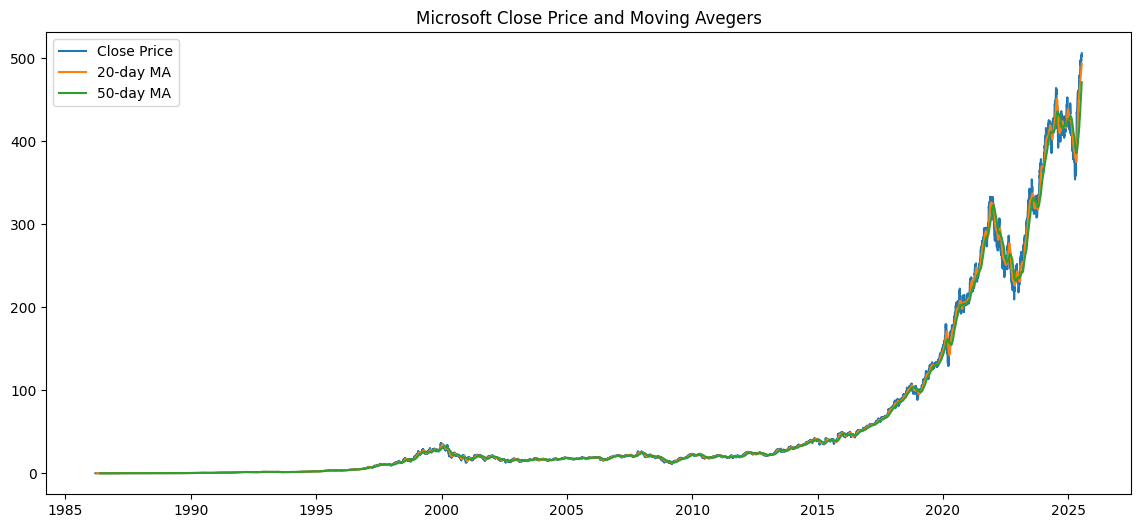

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (14,6))
plt.plot(dataset["Date"],dataset["Close"],label = "Close Price")
plt.plot(dataset["Date"],dataset["MA20"],label = "20-day MA")
plt.plot(dataset["Date"],dataset["MA50"],label = "50-day MA")
plt.legend()
plt.title("Microsoft Close Price and Moving Avegers")

In [24]:
dataset["Daily_Return"] = dataset["Close"].pct_change()
dataset["Volatility_10"] = dataset["Close"].rolling(window=10).std()
dataset = dataset.dropna()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNN



dataset  = dataset.drop(columns = "Date")

x = dataset.drop(columns="Close")
y = dataset["Close"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 0)

sc = StandardScaler()
x_train_scaler = sc.fit_transform(x_train)
x_test_scaler = sc.transform(x_test)


model_list = {
    "Linear Regression" : LinearRegression(),
    "Decision Tree Regressor" : DecisionTreeRegressor(criterion = "squared_error",min_samples_split = 3,random_state=0),
    "Random Forest Regressor" : RandomForestRegressor(n_estimators = 100,min_samples_split = 3,random_state=0),
    "Support Vector Regressor " : SVR(kernel = "rbf",degree = 3,verbose = False,max_iter = -1),
    "KNN " : KNN(n_neighbors = 5,metric = "minkowski")
}

results = {}

for name, model in model_list.items():
    model.fit(x_train_scaler,y_train)
    y_pred = model.predict(x_test_scaler)
    print(f"{name} R2: {r2_score(y_test,y_pred)}")
    print(f"{name} MSE: {mean_squared_error(y_test,y_pred)}")
    results[name] = y_pred
    print("*"*30)

Linear Regression R2: 0.9999541984943163
Linear Regression MSE: 0.5456317457828058
******************************
Decision Tree Regressor R2: 0.9998085415396649
Decision Tree Regressor MSE: 2.2808379855241316
******************************
Random Forest Regressor R2: 0.9999098448208391
Random Forest Regressor MSE: 1.0740155167975356
******************************
Support Vector Regressor  R2: 0.9077140045941264
Support Vector Regressor  MSE: 1099.3998566858388
******************************
KNN  R2: 0.9968918571089764
KNN  MSE: 37.02719826472114
******************************


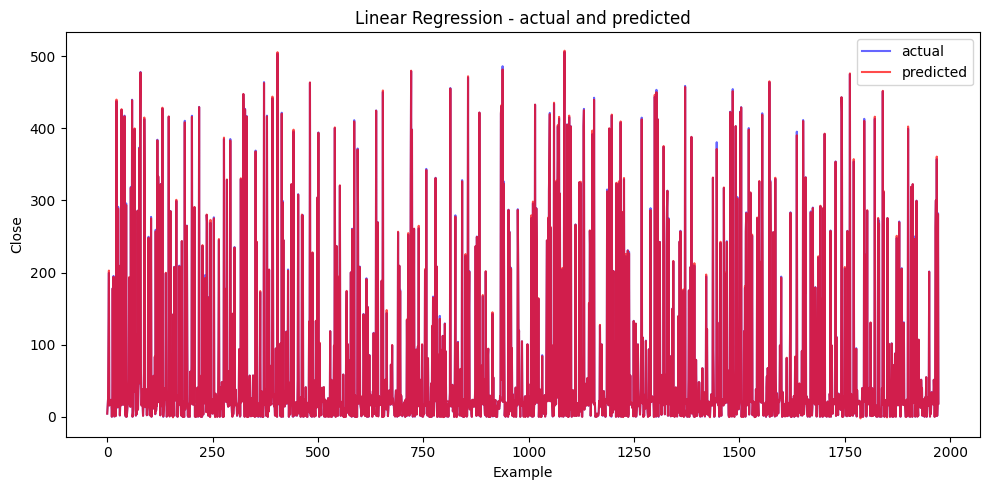

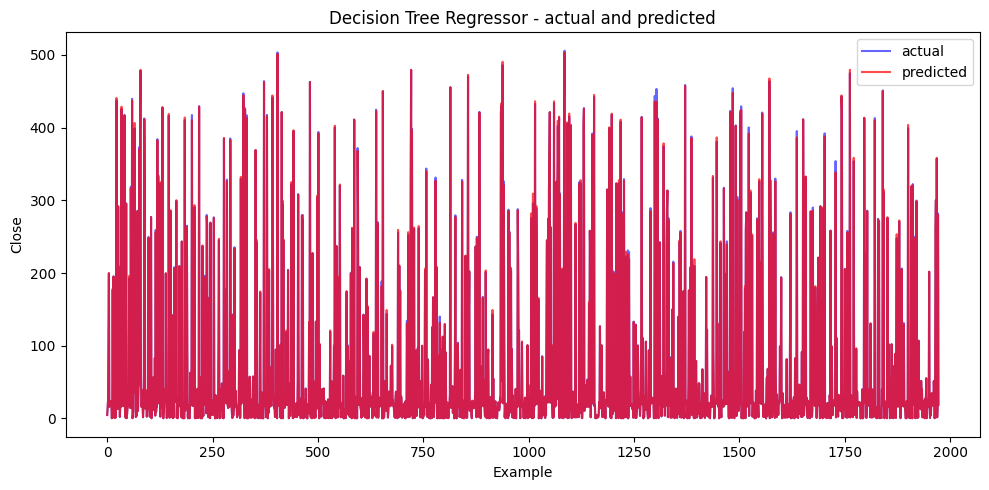

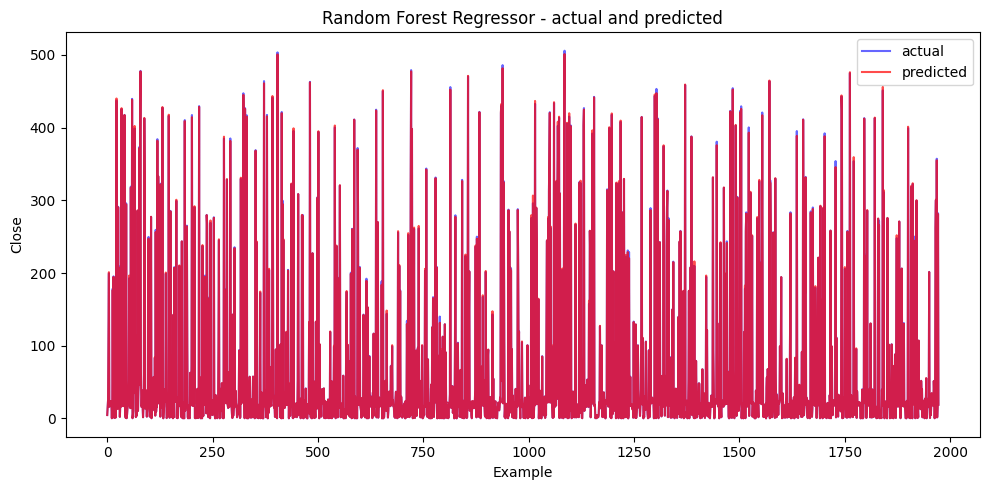

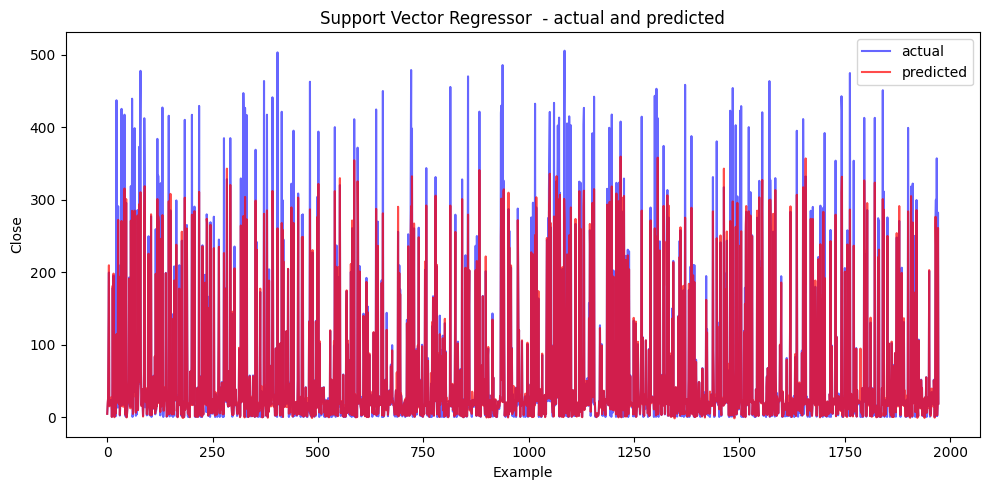

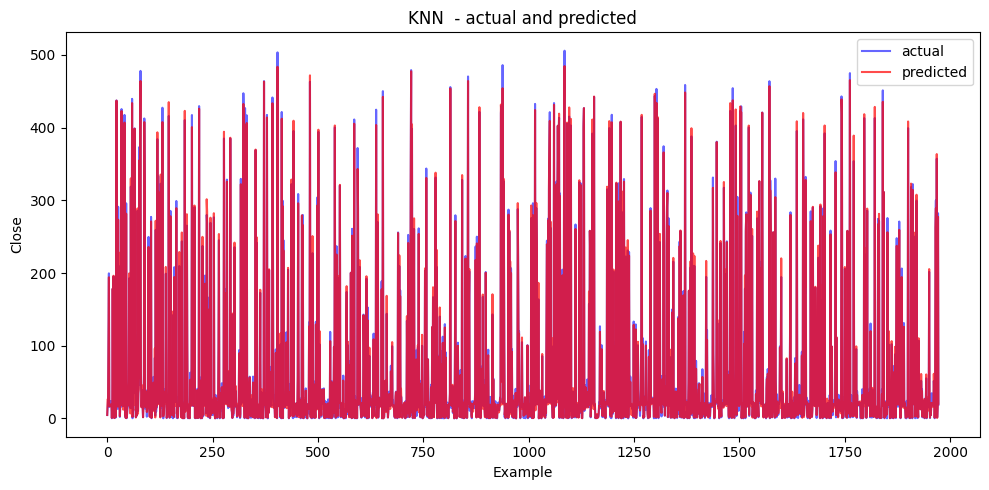

In [26]:
for name, y_pred in results.items():
    plt.figure(figsize=(10,5))
    plt.plot(y_test.reset_index(drop=True), label='actual', color='blue', alpha=0.6)
    plt.plot(pd.Series(y_pred), label='predicted', color='red', alpha=0.7)
    plt.title(f"{name} - actual and predicted")
    plt.xlabel("Example")
    plt.ylabel("Close")
    plt.legend()
    plt.tight_layout()